In [1]:
import h5py
from glob import glob
import sys, scipy
from scipy.stats import chi2
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.utils import shuffle

import gpustat
gpustat.print_gpustat()
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE" # Some versions of HDF5 require this
os.environ['CUDA_VISIBLE_DEVICES']='4' # This is to choose which GPU to use

import sys
import tensorflow as tf

import keras
from keras import backend as K
#sys.setrecursionlimit(1500)

import h5py
import numpy as np

from torch.utils.data import Dataset, DataLoader # The model is in keras, but I use pytorch for data generator

print(keras.__version__)

gpu-4-culture-plate-sm  Wed Jul 10 09:36:33 2019
[0] GeForce GTX 1080 | 27'C,   0 % |  7779 /  8114 MB | llayer(7769M)
[1] GeForce GTX 1080 | 28'C,   0 % |  7779 /  8114 MB | thong(7769M)
[2] GeForce GTX 1080 | 37'C,  11 % |   355 /  8114 MB | thong(345M)
[3] GeForce GTX 1080 | 25'C,   0 % |  7781 /  8114 MB | thong(7771M)
[4] GeForce GTX 1080 | 31'C,   0 % |     0 /  8114 MB |
[5] GeForce GTX 1080 | 32'C,   0 % |  7814 /  8114 MB | thong(5917M) thong(1887M)
[6] GeForce GTX 1080 | 29'C,   0 % |     0 /  8114 MB |
[7] GeForce GTX 1080 | 27'C,   0 % |  7329 /  8114 MB | thong(7319M)


Using TensorFlow backend.


2.0.9


In [2]:
INPUT_LENGTH = 10 # number of particles to consider in 1 event
BATCH_SIZE = 10

# this is the location on the caltech machine. Change it according to your case
base_dir = '/bigdata/shared/TOPCLASS2018/BSMAnomaly_IsoLep_lt_45_pt_gt_23_NEW/SMmix_qcd_tt_w_z/' 
bsm_dir = '/bigdata/shared/TOPCLASS2018/BSMAnomaly_IsoLep_lt_45_pt_gt_23_NEW/sorted_Pt_Ato4l_Htn_Htt_LQ_100k'
# I made a copy of data to lxplus: /eos/project/d/dshep/BSM_Detection/THONG_TMP/SMmix_qcd_tt_w_z
# The particles in the event are currently sorted by pT

In [3]:
class SimpleEventSequence(Dataset):
    def __init__(self, data_x, data_y):
        self.len = data_x.shape[0]
        self.data_x = torch.from_numpy(data_x).float()
        self.data_y = torch.from_numpy(data_y)
        
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return (self.data_x[idx], self.data_y[idx])

class EventSequence(Dataset):
    def check_data(self, file_names):
        num_data = 0
        thresholds = [0]
        for in_file_name in file_names:
            h5_file = h5py.File( in_file_name, 'r' )
            X = h5_file[self.feature_name]
            if hasattr(X, 'keys'):
                num_data += len(X[X.keys()[0]])
                thresholds.append(num_data)
            else:
                num_data += len(X)
                thresholds.append(num_data)
            h5_file.close()
        return (num_data, thresholds)

    def __init__(self, dir_name, feature_name = 'Particles', label_name = 'Labels', sequence_length=50, verbose=False):
        self.feature_name = feature_name
        self.label_name = label_name
        self.file_names = glob(dir_name+'/*.h5')
        self.num_data, self.thresholds = self.check_data(self.file_names)
        self.sequence_length = sequence_length
        self.file_index = 0
        self.h5_file = h5py.File(self.file_names[self.file_index],'r')
        self.get_data()
        self.verbose=verbose
        
    def get_data(self):
        self.X = np.array(self.h5_file.get(self.feature_name))[:,:self.sequence_length,4:7] # 4:7 is positions of pT, eta, phi
        self.Y = np.array(self.h5_file.get(self.label_name))
#        self.X[:,0] = self.X[:,0]/15.

    def is_numpy_array(self, data):
        return isinstance(data, np.ndarray)

    def get_num_samples(self, data):
        """Input: dataset consisting of a numpy array or list of numpy arrays.
            Output: number of samples in the dataset"""
        if self.is_numpy_array(data):
            return len(data)
        else:
            return len(data[0])

    def get_index(self, idx):
        """Translate the global index (idx) into local indexes,
        including file index and event index of that file"""
        file_index = next(i for i,v in enumerate(self.thresholds) if v > idx)
        file_index -= 1
        event_index = idx - self.thresholds[file_index]
        return file_index, event_index

    def get_thresholds(self):
        return self.thresholds

    def __len__(self):
        return self.num_data

    def __getitem__(self, idx):
        file_index, event_index = self.get_index(idx)
        
        if file_index != self.file_index:
            self.h5_file.close()
            self.file_index = file_index
            if self.verbose: 
                print("Opening new file {}".format(self.file_names[self.file_index]))
            self.h5_file = h5py.File(self.file_names[self.file_index],'r')
            self.get_data()
            self.X, self.Y = shuffle(self.X, self.Y)
        #return [self.X[event_index], np.argmax(self.Y[event_index])]
        X_ = self.X[event_index]
        # Scale down pT
        X = X_
        X[:,0] = X_[:,0]/10.
        X = X.flatten()
        Y_ = self.Y[event_index]
        if not np.any(X): # empty array, go to the next event
            print("Empty event. Skipping.")
            return self.__getitem__(idx+1)
        return (X, X)

    
class EventLabelSequence(EventSequence):

    def __getitem__(self, idx):
        file_index, event_index = self.get_index(idx)
        
        if file_index != self.file_index:
            self.h5_file.close()
            self.file_index = file_index
            if self.verbose: 
                print("Opening new file {}".format(self.file_names[self.file_index]))
            self.h5_file = h5py.File(self.file_names[self.file_index],'r')
            self.get_data()
            self.X, self.Y = shuffle(self.X, self.Y)
        #return [self.X[event_index], np.argmax(self.Y[event_index])]
        X_ = self.X[event_index]
        # Scale down pT
        X = X_
        X[:,0] = X_[:,0]/10.
        X = X.flatten()
        Y_ = self.Y[event_index]
        if not np.any(X): # empty array
            print("Empty event. Skipping.")
            return self.__getitem__(idx+1)
        return (X, Y_)
        

In [4]:
from keras.models import Model
from keras.layers import Input, GRU, LSTM, Dense, Reshape, Lambda, Concatenate, Flatten
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

InputLayer = Input(shape=(INPUT_LENGTH*3,))
enc = Dense(INPUT_LENGTH*2, activation='relu')(InputLayer)
enc = Dense(INPUT_LENGTH, activation='relu')(enc)
dec = Dense(INPUT_LENGTH*2, activation='relu')(enc)
dec = Dense(INPUT_LENGTH*3, activation=None)(dec)

####

def custom_loss(y_truth, y_pred):
    
    return K.mean(K.mean(K.mean(K.abs(y_pred-y_truth), axis=-1), axis=-1), axis=-1)

####

model = Model(inputs=InputLayer, outputs=dec)
model.compile(optimizer='adam', loss='mae')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 30)                630       
Total params: 1,680
Trainable params: 1,680
Non-trainable params: 0
_________________________________________________________________


In [5]:
train_loader = DataLoader(EventSequence(dir_name=base_dir+'/train/',
                                    feature_name ='Particles', label_name = 'Labels', sequence_length=INPUT_LENGTH, verbose=False), 
                                    batch_size = BATCH_SIZE, shuffle=False,num_workers=3)
    
val_loader = DataLoader(EventSequence(dir_name=base_dir+'/val/',
                        feature_name ='Particles',label_name = 'Labels', sequence_length=INPUT_LENGTH, verbose=False), 
                        batch_size = BATCH_SIZE, shuffle=False,num_workers=3)

# Turn this data loader into a generator
def cycle(iterable):
    while True:
        for x in iterable:
            yield [x[0].numpy(), x[1].numpy()]
            
train_iter = iter(cycle(train_loader))
val_iter = iter(cycle(val_loader))

history = model.fit_generator(train_iter,
        steps_per_epoch=len(train_loader),
        epochs=200,
        validation_data=val_iter,
        validation_steps=len(val_loader),
        callbacks=[
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
            TerminateOnNaN(), 
            EarlyStopping(patience=7,verbose=1)
                  ])

Epoch 1/200
7189/7189 [==============================] - 75s 10ms/step - loss: 0.9499 - val_loss: 0.8947
Epoch 2/200
7189/7189 [==============================] - 54s 8ms/step - loss: 0.8851 - val_loss: 0.8827
Epoch 3/200
7189/7189 [==============================] - 57s 8ms/step - loss: 0.8820 - val_loss: 0.8812
Epoch 4/200
7189/7189 [==============================] - 55s 8ms/step - loss: 0.8809 - val_loss: 0.8825
Epoch 5/200
7189/7189 [==============================] - 55s 8ms/step - loss: 0.8802 - val_loss: 0.8824
Epoch 6/200
7189/7189 [==============================] - 57s 8ms/step - loss: 0.8797 - val_loss: 0.8813
Epoch 7/200
7186/7189 [============================>.] - ETA: 0s - loss: 0.8792
Epoch 00007: reducing learning rate to 0.00020000000949949026.
7189/7189 [==============================] - 59s 8ms/step - loss: 0.8792 - val_loss: 0.8811
Epoch 8/200
7189/7189 [==============================] - 60s 8ms/step - loss: 0.8722 - val_loss: 0.8744
Epoch 9/200
7189/7189 [=============

In [6]:
newBATCH_SIZE = BATCH_SIZE * 10

sm_val_loader = DataLoader(EventLabelSequence(dir_name=base_dir+'/val/',
                        feature_name ='Particles',label_name = 'Labels', sequence_length=INPUT_LENGTH, verbose=False), 
                        batch_size = newBATCH_SIZE, shuffle=False,num_workers=3)

def eval_loss(true, pred):
    return np.array(np.sum(np.absolute(pred - true),axis=-1))

for batch_idx, data in enumerate(sm_val_loader):
    x = data[0].numpy()
    output_sm = model.predict_on_batch(x)
    _loss_sm = eval_loss(x, output_sm)
    
    if batch_idx == 0: 
        loss_sm = _loss_sm
        out_sm = output_sm
        in_sm = x
    else:
        loss_sm = np.concatenate((loss_sm,_loss_sm))
        out_sm = np.concatenate((out_sm,output_sm))
        in_sm = np.concatenate((in_sm,x))
        
print(loss_sm.shape)

(30810,)


In [7]:
# plt.hist(in_sm[:,:,0].flatten(), bins=50, range=(0,10), label='SM In')
# plt.hist(out_sm[:,:,0].flatten(),histtype='step',bins=50, range=(0,10), label='SM Out')
# #plt.hist(in_sm[:,:,0].flatten(), bins=50, range=(0,100), label='SM In')
# plt.legend(loc='best')
# plt.xlabel('PT')
# plt.show()

# plt.hist(in_sm[:,:,1].flatten(), bins=50, range=(-5,5), label='SM In')
# plt.hist(out_sm[:,:,1].flatten(),histtype='step',bins=50,range=(-5,5),  label='SM Out')
# #plt.hist(in_sm[:,:,1].flatten(), bins=50, range=(0,100), label='SM In')
# plt.legend(loc='best')
# plt.xlabel('Eta')
# plt.show()

# plt.hist(in_sm[:,:,2].flatten(), bins=50, range=(-3.2, 3.2),  label='SM In')
# plt.hist(out_sm[:,:,2].flatten(),histtype='step',bins=50,range=(-3.2, 3.2), label='SM Out')
# plt.legend(loc='best')
# plt.xlabel('Phi')
# plt.show()

In [8]:
bsm_loader = DataLoader(EventLabelSequence(dir_name=bsm_dir+'/train/',
                        feature_name ='Particles',label_name = 'Labels', sequence_length=INPUT_LENGTH, verbose=False), 
                        batch_size = newBATCH_SIZE, shuffle=False,num_workers=3)


for batch_idx, data in enumerate(bsm_loader):
    x = data[0].numpy()
    y = data[1].numpy()
    output_bsm = model.predict_on_batch(x)
    _loss_bsm = eval_loss(x, output_bsm)
    
    if batch_idx == 0: 
        loss_bsm = _loss_bsm
        out_bsm = output_bsm
        in_bsm = x
        label_bsm = y
    else:
        loss_bsm = np.concatenate((loss_bsm,_loss_bsm))
        out_bsm = np.concatenate((out_bsm,output_bsm))
        in_bsm = np.concatenate((in_bsm,x))
        label_bsm = np.concatenate((label_bsm,y))
        
print(loss_bsm.shape)

(346000,)


In [9]:
label_bsm_index = np.argmax(label_bsm, axis=1)
print(label_bsm_index.shape)

(346000,)


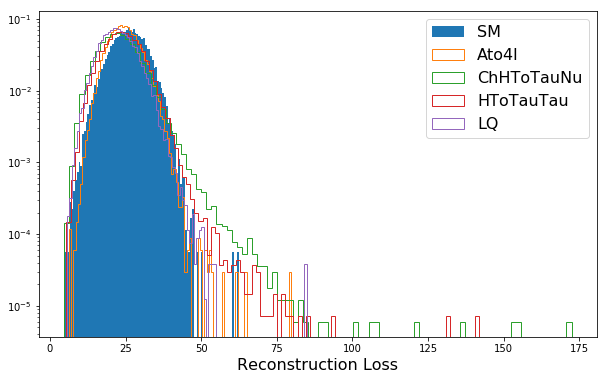

In [10]:
BSM = ['Ato4l','ChHToTauNu','HToTauTau','LQ']
plt.figure(figsize=(10,6))
plt.hist(loss_sm,bins=100,label='SM', normed=True)
for i,name in enumerate(BSM):
    plt.hist(loss_bsm[label_bsm_index==i],bins=100,label=name, histtype='step', normed=True)
plt.legend(loc='best',fontsize=16)
plt.xlabel('Reconstruction Loss', fontsize=16)
plt.yscale('log',fontsize=16)


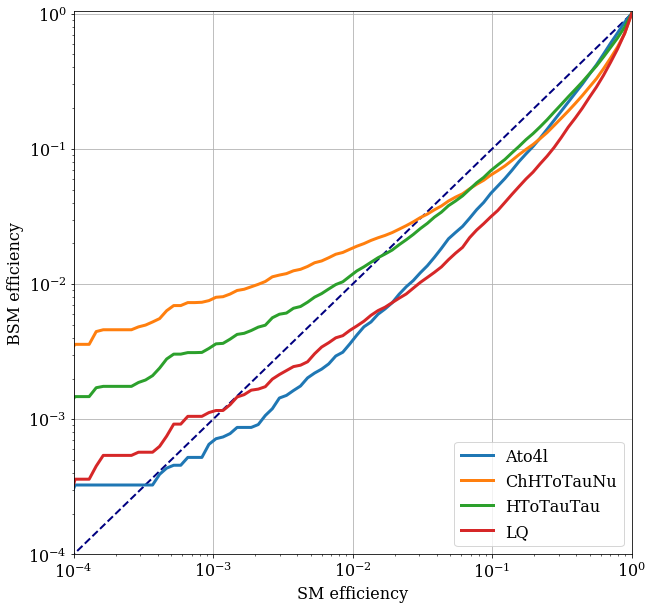

In [11]:
import matplotlib 

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 25,
         }

matplotlib.rc('font', **font)
matplotlib.rcParams['figure.figsize'] = 12, 9
matplotlib.rcParams['lines.linewidth'] = 3
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

p_SM = np.logspace(base=10, start=-5, stop=0, num=100)
p_SM[-1] = 0.999

f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax_arr_ROC.set_xlim([1e-4, 1.0])
ax_arr_ROC.set_ylim([1e-4, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
ax_arr_ROC.ticklabel_format()
ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.grid()

# First sort the SM distribution
sm_sort = np.argsort(loss_sm)
sm_re_loss = loss_sm[sm_sort]

# Find out the sm threshold values corresponding to each percentile in p_SM
frac = np.cumsum(np.ones_like(sm_re_loss)/len(sm_re_loss)) # an array of fraction (1/n, 2/n, etc.)
indices_of_thresholds = np.argmax(frac > np.atleast_2d(1-p_SM).T, axis=1) # which element closest to each value in p_SM
sm_thresholds = sm_re_loss[indices_of_thresholds] # what are the corresponding threshold values

for i,name in enumerate(BSM):
    bsm = loss_bsm[label_bsm_index==i]
    # For each of the threshold above, compute the fraction of BSM events that would be selected at that SM threshold
    bsm_frac = np.float64(np.sum(bsm > np.atleast_2d(sm_thresholds).T, axis=1, dtype=np.float128)/len(bsm))
    # Voila
    ax_arr_ROC.plot(p_SM,bsm_frac,label=name)

ax_arr_ROC.legend(loc="lower right", fontsize=16)

## 

In [12]:
# Save model
import json
model_json = model.to_json()
with open('SimpleSeq2Seq_Keras.json','w') as out:
    json.dump(model_json, out)
model.save_weights('SimpleSeq2Seq_Kerasweights.h5')